In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the MNIST dataset

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We can play with it:

(1, 784)


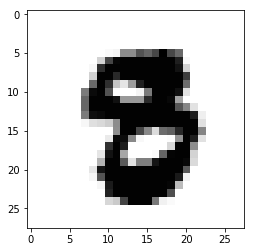

In [5]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

# Definitions

In [6]:
def discriminator(images, reuse=False):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:

        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [7]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable(
        'g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable(
        'g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable(
        'g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable(
        'g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

# Let's try

In [8]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [9]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

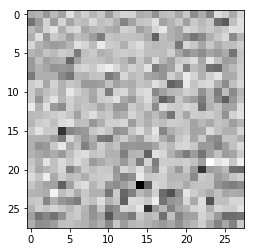

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [11]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape=[None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images

In [12]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [13]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [14]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [15]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [16]:
with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
    tf.summary.scalar('Generator_loss', g_loss)
    tf.summary.scalar('Discriminator_loss_real', d_loss_real)
    tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

    images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
    tf.summary.image('Generated_images', images_for_tensorboard, 5)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.693 dLossFake: 0.721148
dLossReal: 0.072642 dLossFake: 0.355133
dLossReal: 0.00121086 dLossFake: 0.00310802
Iteration: 0 at 2017-12-18 09:43:17.786123


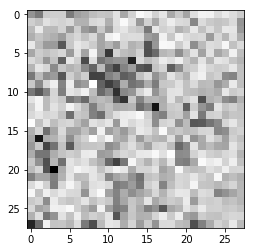

Estimate: [[-6.65206337]]
Iteration: 100 at 2017-12-18 09:45:33.696450


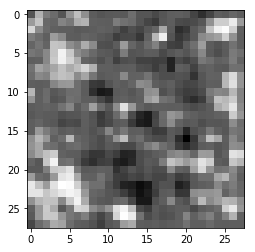

Estimate: [[-7.08326387]]
Iteration: 200 at 2017-12-18 09:47:49.518996


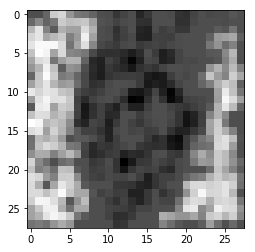

Estimate: [[-8.27619934]]
Iteration: 300 at 2017-12-18 09:50:05.305844


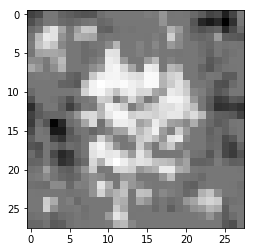

Estimate: [[-14.10836697]]
Iteration: 400 at 2017-12-18 09:52:21.140146


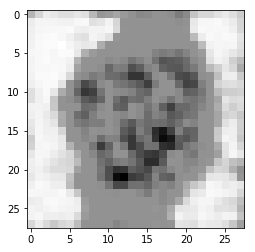

Estimate: [[-14.01385593]]
Iteration: 500 at 2017-12-18 09:54:36.810534


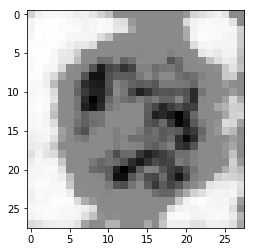

Estimate: [[-9.94695663]]
Iteration: 600 at 2017-12-18 09:56:52.696121


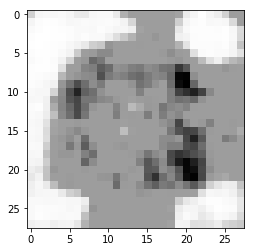

Estimate: [[-10.47499847]]
Iteration: 700 at 2017-12-18 09:59:08.354529


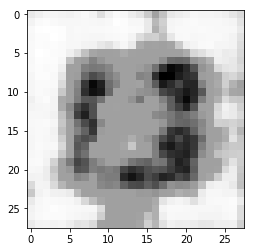

Estimate: [[-9.59849072]]
Iteration: 800 at 2017-12-18 10:01:24.012347


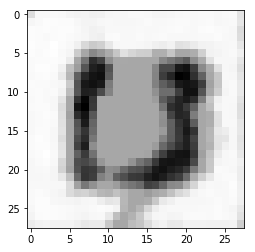

Estimate: [[-9.1718998]]
Iteration: 900 at 2017-12-18 10:03:39.842851


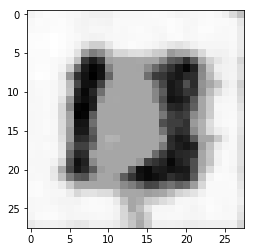

Estimate: [[-8.27368069]]
Iteration: 1000 at 2017-12-18 10:05:55.619954


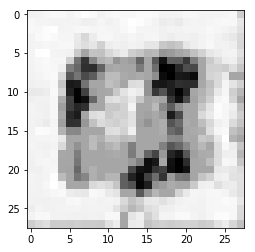

Estimate: [[-5.34249115]]
Iteration: 1100 at 2017-12-18 10:08:11.376551


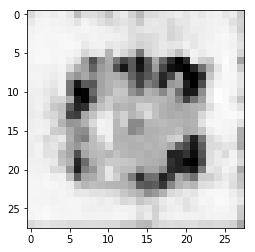

Estimate: [[-16.17140961]]
Iteration: 1200 at 2017-12-18 10:10:27.219817


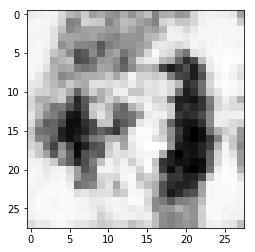

Estimate: [[-7.911201]]
Iteration: 1300 at 2017-12-18 10:12:42.923737


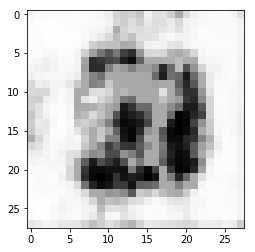

Estimate: [[-19.7742939]]
Iteration: 1400 at 2017-12-18 10:14:58.566372


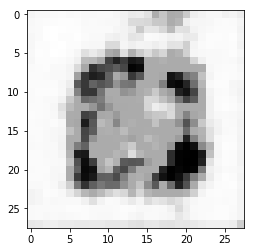

Estimate: [[-25.23173714]]
Iteration: 1500 at 2017-12-18 10:17:14.354444


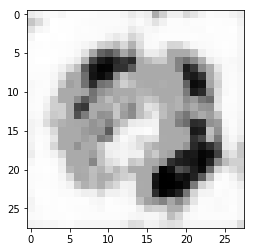

Estimate: [[-20.89380455]]
Iteration: 1600 at 2017-12-18 10:19:30.278587


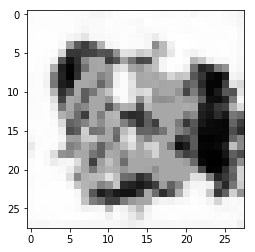

Estimate: [[-11.61158085]]
Iteration: 1700 at 2017-12-18 10:21:48.475036


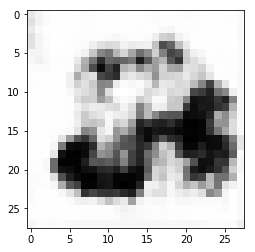

Estimate: [[-13.57818794]]
Iteration: 1800 at 2017-12-18 10:24:04.100214


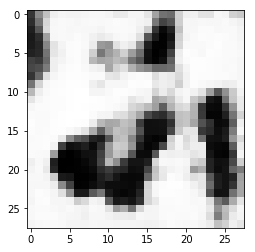

Estimate: [[-7.59649754]]
Iteration: 1900 at 2017-12-18 10:26:19.965323


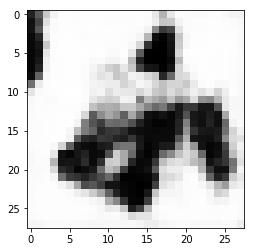

Estimate: [[-6.84875202]]
Iteration: 2000 at 2017-12-18 10:28:35.523367


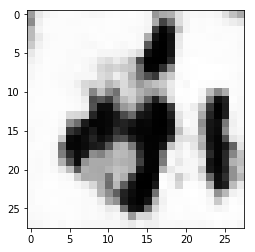

Estimate: [[-8.09814548]]
Iteration: 2100 at 2017-12-18 10:30:51.310401


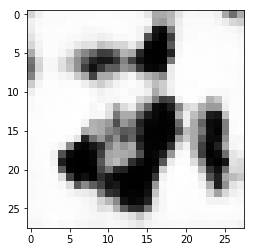

Estimate: [[-9.85433674]]
Iteration: 2200 at 2017-12-18 10:33:07.080131


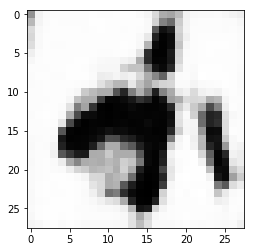

Estimate: [[-7.27885389]]
Iteration: 2300 at 2017-12-18 10:35:22.804758


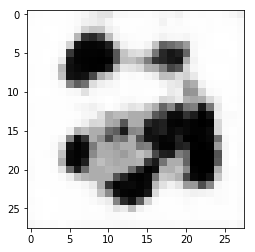

Estimate: [[-10.64961815]]
Iteration: 2400 at 2017-12-18 10:37:38.308660


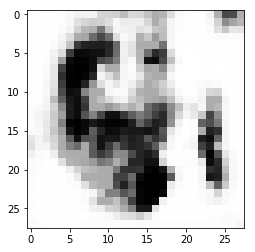

Estimate: [[-7.81172752]]
Iteration: 2500 at 2017-12-18 10:39:54.193836


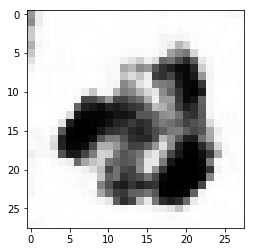

Estimate: [[-9.01951218]]
Iteration: 2600 at 2017-12-18 10:42:09.911820


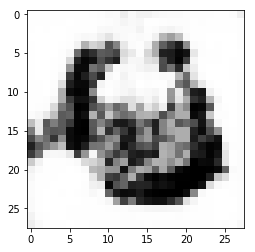

Estimate: [[-9.93118572]]
Iteration: 2700 at 2017-12-18 10:44:25.552397


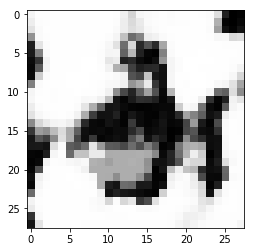

Estimate: [[-7.07673645]]
Iteration: 2800 at 2017-12-18 10:46:41.229863


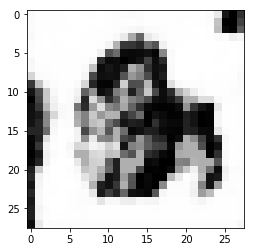

Estimate: [[-7.57103872]]
Iteration: 2900 at 2017-12-18 10:48:57.071923


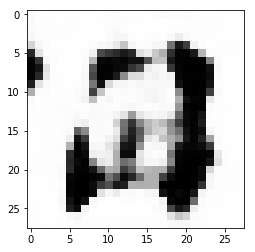

Estimate: [[-7.26797199]]
Iteration: 3000 at 2017-12-18 10:51:13.042843


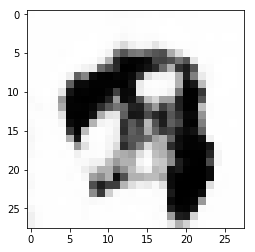

Estimate: [[-7.55550051]]
Iteration: 3100 at 2017-12-18 10:53:28.741483


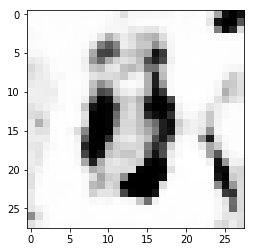

Estimate: [[-10.14826298]]
Iteration: 3200 at 2017-12-18 10:55:47.434944


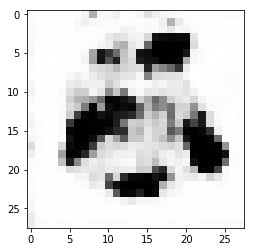

Estimate: [[-6.57876062]]
Iteration: 3300 at 2017-12-18 10:58:03.135795


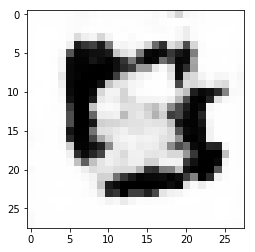

Estimate: [[-4.2213006]]
Iteration: 3400 at 2017-12-18 11:00:18.895116


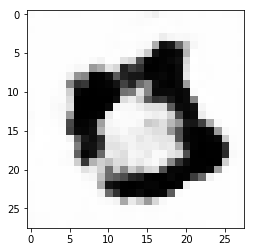

Estimate: [[-6.21120644]]
Iteration: 3500 at 2017-12-18 11:02:34.661522


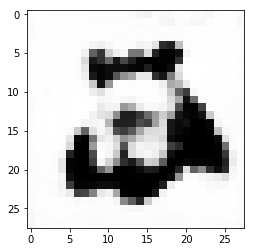

Estimate: [[-13.06816769]]
Iteration: 3600 at 2017-12-18 11:04:50.188802


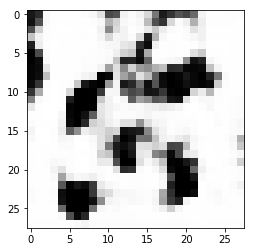

Estimate: [[-8.08210945]]
Iteration: 3700 at 2017-12-18 11:07:05.812239


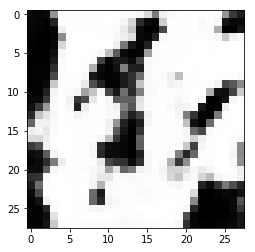

Estimate: [[-7.10301447]]
Iteration: 3800 at 2017-12-18 11:09:21.559228


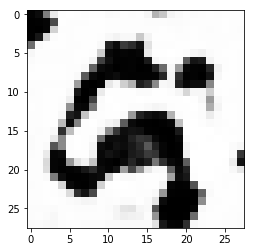

Estimate: [[-7.68998814]]
Iteration: 3900 at 2017-12-18 11:11:37.150188


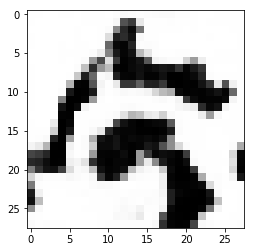

Estimate: [[-6.36196613]]
Iteration: 4000 at 2017-12-18 11:13:53.300544


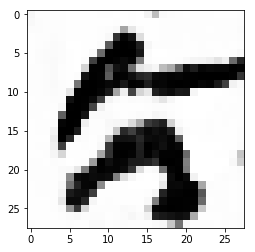

Estimate: [[-10.03184986]]
Iteration: 4100 at 2017-12-18 11:16:09.054222


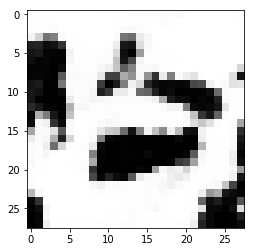

Estimate: [[-7.80872202]]
Iteration: 4200 at 2017-12-18 11:18:25.045703


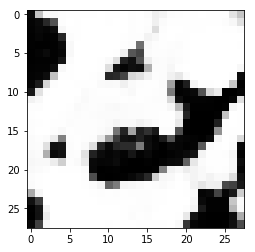

Estimate: [[-5.3253417]]
Iteration: 4300 at 2017-12-18 11:20:41.044270


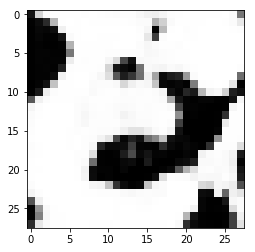

Estimate: [[-4.97285843]]
Iteration: 4400 at 2017-12-18 11:22:57.158171


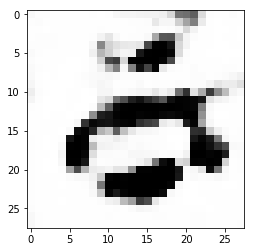

Estimate: [[-8.06042957]]
Iteration: 4500 at 2017-12-18 11:25:13.177794


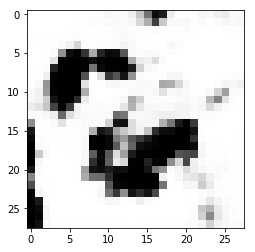

Estimate: [[-23.27555847]]
Iteration: 4600 at 2017-12-18 11:27:29.503933


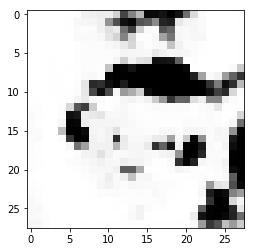

Estimate: [[-10.45009422]]
Iteration: 4700 at 2017-12-18 11:29:45.481214


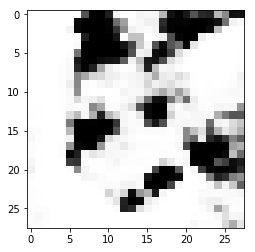

Estimate: [[-8.75872898]]
Iteration: 4800 at 2017-12-18 11:32:01.359909


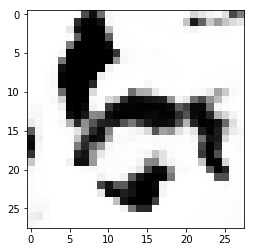

Estimate: [[-54.39834976]]
Iteration: 4900 at 2017-12-18 11:34:17.178702


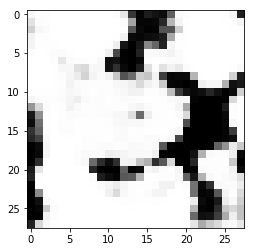

Estimate: [[-22.22826195]]
Iteration: 5000 at 2017-12-18 11:36:33.001207


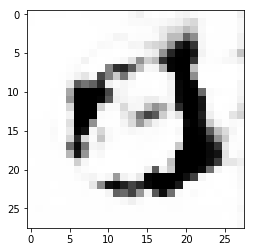

Estimate: [[-35.10050583]]
Iteration: 5100 at 2017-12-18 11:38:49.018853


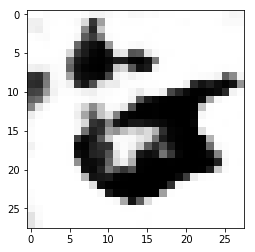

Estimate: [[-20.98429489]]
Iteration: 5200 at 2017-12-18 11:41:05.137543


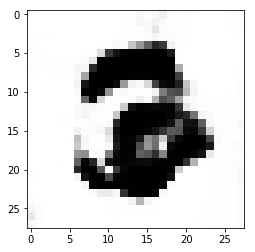

Estimate: [[-28.75973701]]
Iteration: 5300 at 2017-12-18 11:43:20.787561


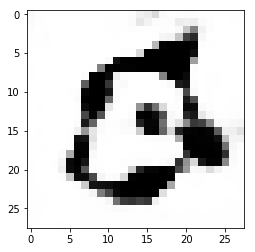

Estimate: [[-26.52577972]]
Iteration: 5400 at 2017-12-18 11:45:36.278481


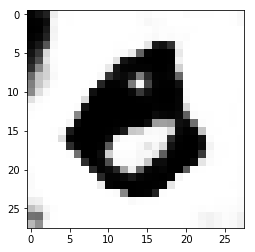

Estimate: [[-21.71674347]]
Iteration: 5500 at 2017-12-18 11:47:51.771858


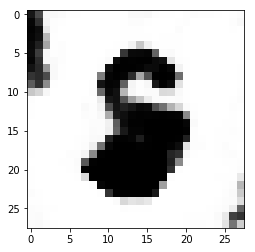

Estimate: [[-54.57341385]]
Iteration: 5600 at 2017-12-18 11:50:07.295840


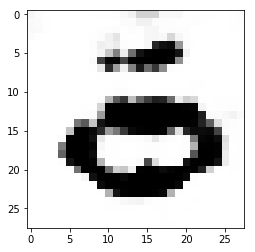

Estimate: [[-45.31490326]]
Iteration: 5700 at 2017-12-18 11:52:22.888037


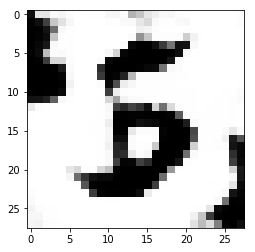

Estimate: [[-44.44831467]]
Iteration: 5800 at 2017-12-18 11:54:38.764170


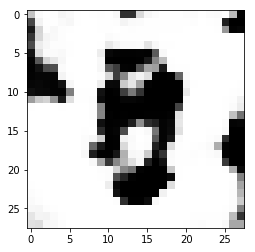

Estimate: [[-39.57413101]]
Iteration: 5900 at 2017-12-18 11:56:54.300754


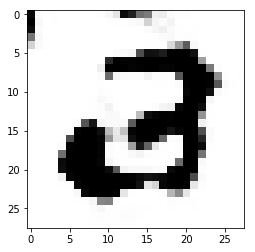

Estimate: [[-29.69702911]]
Iteration: 6000 at 2017-12-18 11:59:09.836871


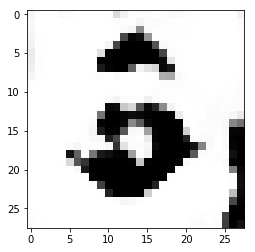

Estimate: [[-34.02722168]]
Iteration: 6100 at 2017-12-18 12:01:25.405568


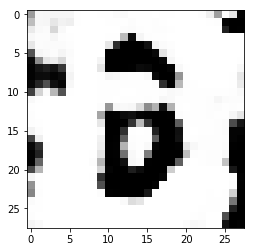

Estimate: [[-34.46559906]]
Iteration: 6200 at 2017-12-18 12:03:40.944840


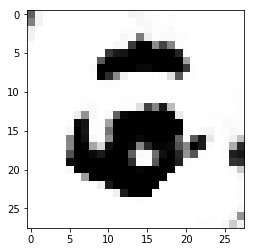

Estimate: [[-34.00846863]]
Iteration: 6300 at 2017-12-18 12:05:56.590663


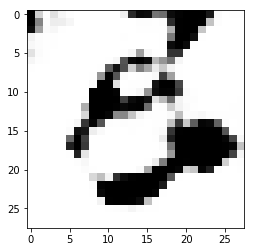

Estimate: [[-25.12115479]]
Iteration: 6400 at 2017-12-18 12:08:12.858298


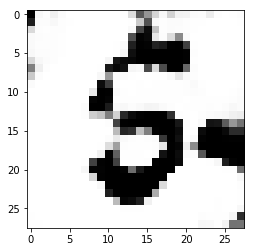

Estimate: [[-26.00580788]]
Iteration: 6500 at 2017-12-18 12:10:29.097125


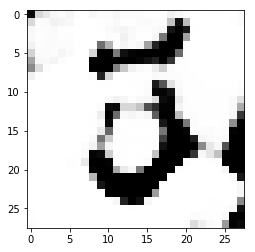

Estimate: [[-23.18263626]]
Iteration: 6600 at 2017-12-18 12:12:45.405571


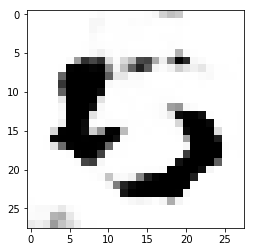

Estimate: [[-26.51675797]]
Iteration: 6700 at 2017-12-18 12:15:01.707223


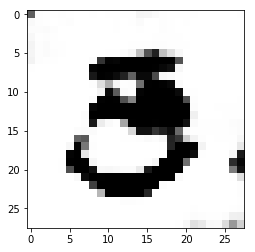

Estimate: [[-30.61779976]]
Iteration: 6800 at 2017-12-18 12:17:17.806992


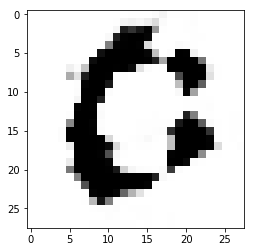

Estimate: [[-35.76173401]]
Iteration: 6900 at 2017-12-18 12:19:34.183907


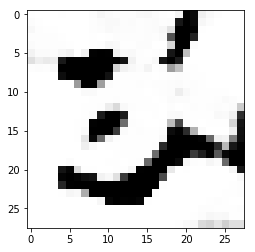

Estimate: [[-30.83601189]]
Iteration: 7000 at 2017-12-18 12:21:50.431770


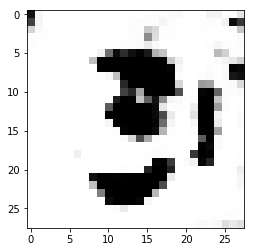

Estimate: [[-24.52680016]]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
            # Every 100 iterations, show a generated image
            print("Iteration:", i, "at", datetime.datetime.now())
            z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
            generated_images = generator(z_placeholder, 1, z_dimensions)
            images = sess.run(generated_images, {z_placeholder: z_batch})
            plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
            plt.show()

            # Show discriminator's estimate
            im = images[0].reshape([1, 28, 28, 1])
            result = discriminator(x_placeholder)
            estimate = sess.run(result, {x_placeholder: im})
            print("Estimate:", estimate)

In [ ]:
with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
    # Every 100 iterations, show a generated image
    print("Iteration: i at", datetime.datetime.now())
    z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
    generated_images = generator(z_placeholder, 1, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
    plt.show()

    # Show discriminator's estimate
    im = images[0].reshape([1, 28, 28, 1])
    result = discriminator(x_placeholder)
    estimate = sess.run(result, {x_placeholder: im})
    print("Estimate:", estimate)